In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns
import numpy as np
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel
import daft

All the text quoted are from the book [Statistical Rethinking by Richard McElreath](https://xcelab.net/rm/statistical-rethinking/) chapter 6.

The snippet code for the DAG display, backdoor path and contitional independecies are all credited to [Kapil Sachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

## The Fork
In a fork a variable confounds others. 
In the example below, **C** cofounds **A** and **B**. And that means that if we want to learn **B** then **A** tells nothing about it when we condition on **C**.
<br>
<br>
**A** and **B** are independent, conditional on **C**.<br>
Conditioning on **C** blocks the path between **A** and **B**.

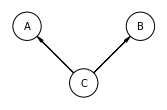

In [2]:
# the fork
dag_fork = CausalGraphicalModel(
    nodes=["A", "B", "C"], edges=[("C", "A"), ("C", "B")]
)

pgm = daft.PGM()
coordinates = {"A":(0, 1), "C":(1, 0), "B":(2, 1)}

for node in dag_fork.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_fork.dag.edges:
    pgm.add_edge(*edge)
pgm.render();

Lets run 2 simulations to see how the fork works. 
<br>
First we need to simulate some data.

In [3]:
SAMP_SIZE = 100

np.random.seed(89)
C = stats.norm.rvs(size=SAMP_SIZE) 
B = stats.norm.rvs(C)
A = stats.norm.rvs(C)

df = pd.DataFrame.from_dict({"A": A, "B": B, "C": C})

Regressing **B** on **A** we have:

In [4]:
with pm.Model() as m_fork:
    a = pm.Normal('a', mu=0, sigma=1)
    bA = pm.Normal('bA', mu=0, sigma=1)
    
    mu = a + bA*df.A
    sigma = pm.Exponential('sigma', 1)
    
    B = pm.Normal('B', mu=mu, sigma=sigma, observed=df.B)
    
    m_fork_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 6518.92draws/s]


In [5]:
az.summary(m_fork_trace, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.14,0.13,-0.41,0.10
bA,0.45,0.09,0.28,0.62
sigma,1.28,0.09,1.12,1.45


We can see by the coeficient **bA** that **A** has some positive correlation with **B**.  

Regressing **B** on **A** and **C**:

In [6]:
with pm.Model() as m_fork:
    a = pm.Normal('a', mu=0, sigma=1)
    bA = pm.Normal('bA', mu=0, sigma=1)
    bC = pm.Normal('bC', mu=0, sigma=1)
    
    mu = a + bA*df.A + bC*df.C
    sigma = pm.Exponential('sigma', 1)
    
    B = pm.Normal('B', mu=mu, sigma=sigma, observed=df.B)
    
    m_fork_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bC, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3980.59draws/s]


In [7]:
az.summary(m_fork_trace, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.03,0.11,-0.23,0.17
bA,-0.11,0.11,-0.32,0.09
bC,1.14,0.16,0.83,1.45
sigma,1.04,0.08,0.90,1.19


However, when we add **C** in the model, which is the confounding, **A** doesn't tell anything else about **B**. That can be seen by the **A**'s coeficient being around zero.

## The Pipe
As for the Pipe, when we condition on **C** we block the path between **A** and **B**.

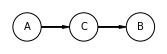

In [8]:
# the pipe
dag_pipe = CausalGraphicalModel(
    nodes=["A", "B", "C"], edges=[("A", "C"), ("C", "B")]
)

pgm = daft.PGM()
coordinates = {"A":(0, 0), "C":(1, 0), "B":(2, 0)}

for node in dag_pipe.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_pipe.dag.edges:
    pgm.add_edge(*edge)
pgm.render();

Bellow we simulate the data.

In [9]:
SAMP_SIZE = 100

np.random.seed(89)
A = stats.norm.rvs(size=SAMP_SIZE) 
C = stats.norm.rvs(A)
B = stats.norm.rvs(C)

df = pd.DataFrame.from_dict({"A": A, "B": B, "C": C})

Regressing **B** on **A** we have:

In [10]:
with pm.Model() as m_pipe:
    a = pm.Normal('a', mu=0, sigma=1)
    bA = pm.Normal('bA', mu=0, sigma=1)
    
    mu = a + bA*df.A
    sigma = pm.Exponential('sigma', 1)
    
    B = pm.Normal('B', mu=mu, sigma=sigma, observed=df.B)
    
    m_pipe_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 6191.90draws/s]


In [11]:
az.summary(m_pipe_trace, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.08,0.13,-0.17,0.31
bA,1.15,0.14,0.90,1.43
sigma,1.33,0.10,1.16,1.51


The coeficient **bA** shows a high positive correlation between **A** and **B**.  

Regressing **B** on **A** and **C**:

In [12]:
with pm.Model() as m_pipe:
    a = pm.Normal('a', mu=0, sigma=1)
    bA = pm.Normal('bA', mu=0, sigma=1)
    bC = pm.Normal('bC', mu=0, sigma=1)
    
    mu = a + bA*df.A + bC*df.C
    sigma = pm.Exponential('sigma', 1)
    
    B = pm.Normal('B', mu=mu, sigma=sigma, observed=df.B)
    
    m_pipe_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bC, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4500.17draws/s]


In [13]:
az.summary(m_pipe_trace, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.12,0.10,-0.08,0.29
bA,0.27,0.14,0.01,0.53
bC,0.88,0.09,0.70,1.05
sigma,0.96,0.07,0.83,1.09


However, when we condition on **C** the information of **A** is blocked and we can see a coeficient closer to zero (the more data we have the closer to zero it will be).

## The Collider
The collider is an interesting case, on the diagram bellow, contrary to the 2 previous cases, the information does not flow between **A** and **B** if we don't condition on **C**.

It's important to notice that when conditioning on **C** and allows information to flow it does not create any casual influence between **A** and **B**.

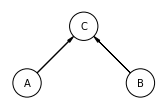

In [14]:
# the collider
dag_coll = CausalGraphicalModel(
    nodes=["A", "B", "C"], edges=[("A", "C"), ("B", "C")]
)

pgm = daft.PGM()
coordinates = {"A":(0, 0), "C":(1, 1), "B":(2, 0)}

for node in dag_coll.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_coll.dag.edges:
    pgm.add_edge(*edge)
pgm.render();

In [15]:
SAMP_SIZE = 100

np.random.seed(89)
A = stats.norm.rvs(size=SAMP_SIZE) 
B = stats.norm.rvs(size=SAMP_SIZE)
C = stats.norm.rvs(A+B)

df = pd.DataFrame.from_dict({"A": A, "B": B, "C": C})

Regressing **B** on **A** we have:

In [16]:
with pm.Model() as m_coll:
    a = pm.Normal('a', mu=0, sigma=1)
    bA = pm.Normal('bA', mu=0, sigma=1)
    
    mu = a + bA*df.A
    sigma = pm.Exponential('sigma', 1)
    
    B = pm.Normal('B', mu=mu, sigma=sigma, observed=df.B)
    
    m_coll_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 6301.06draws/s]


In [17]:
az.summary(m_coll_trace, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.05,0.11,-0.26,0.15
bA,0.02,0.11,-0.18,0.24
sigma,1.04,0.08,0.90,1.18


The coeficient **bA** shows no correlation between **A** and **B**.  

Regressing **B** on **A** and **C**:

In [18]:
with pm.Model() as m_coll:
    a = pm.Normal('a', mu=0, sigma=1)
    bA = pm.Normal('bA', mu=0, sigma=1)
    bC = pm.Normal('bC', mu=0, sigma=1)
    
    mu = a + bA*df.A + bC*df.C
    sigma = pm.Exponential('sigma', 1)
    
    B = pm.Normal('B', mu=mu, sigma=sigma, observed=df.B)
    
    m_coll_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bC, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4265.16draws/s]


In [19]:
az.summary(m_coll_trace, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.08,0.08,-0.22,0.06
bA,-0.60,0.11,-0.79,-0.41
bC,0.54,0.06,0.43,0.64
sigma,0.75,0.05,0.66,0.86


However, when we condition on **C** the information of **A** flows to **B**. We can notice this by the considerable negative coeficient **bA**.

## The Descendant
Conditioning on a descendant partially conditions on its parent.
For the DAG bellow, conditioning on **D** partially conditions on **C** and we have as a result some information flowing from **A** to **B** even by not conditioning on **CC**.

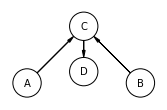

In [20]:
# the descendant
dag_desc = CausalGraphicalModel(
    nodes=["A", "B", "C", "D"], edges=[("A", "C"), ("B", "C"), ("C", "D")]
)

pgm = daft.PGM()
coordinates = {"A":(0, 0), "C":(1, 1), "D":(1, 0.2), "B":(2, 0)}

for node in dag_desc.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_desc.dag.edges:
    pgm.add_edge(*edge)
pgm.render();

In [21]:
SAMP_SIZE = 100

np.random.seed(89)
A = stats.norm.rvs(size=SAMP_SIZE) 
B = stats.norm.rvs(size=SAMP_SIZE)
C = stats.norm.rvs(A+B)
D = stats.norm.rvs(C)

df = pd.DataFrame.from_dict({"A": A, "B": B, "C": C, "D": D})

Regressing **B** on **A** we have:

In [22]:
with pm.Model() as m_desc:
    a = pm.Normal('a', mu=0, sigma=1)
    bA = pm.Normal('bA', mu=0, sigma=1)
    
    mu = a + bA*df.A
    sigma = pm.Exponential('sigma', 1)
    
    B = pm.Normal('B', mu=mu, sigma=sigma, observed=df.B)
    
    m_desc_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5423.34draws/s]


In [23]:
az.summary(m_desc_trace, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.04,0.10,-0.22,0.15
bA,0.03,0.11,-0.19,0.23
sigma,1.04,0.08,0.90,1.19


The coeficient **bA** shows no correlation between **A** and **B**.  

Regressing **B** on **A** and **D**:

In [24]:
with pm.Model() as m_desc:
    a = pm.Normal('a', mu=0, sigma=1)
    bA = pm.Normal('bA', mu=0, sigma=1)
    bD = pm.Normal('bD', mu=0, sigma=1)
    
    mu = a + bA*df.A + bD*df.D
    sigma = pm.Exponential('sigma', 1)
    
    B = pm.Normal('B', mu=mu, sigma=sigma, observed=df.B)
    
    m_desc_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bD, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4602.04draws/s]


In [25]:
az.summary(m_desc_trace, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.08,0.09,-0.26,0.08
bA,-0.36,0.12,-0.59,-0.15
bD,0.31,0.06,0.21,0.41
sigma,0.91,0.07,0.78,1.03


By conditioning on **D** some information then flows from **A** to **B**.

## Exploring DAGs

Consider the DAG example bellow from *The Book of Why by Judea Pearl* - Chapter 4 - Game 5.

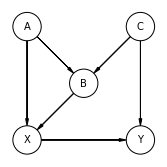

In [26]:
dag_ex = CausalGraphicalModel(
    nodes=["A", "B", "C", "X", "Y"], 
    edges=[("A", "B"), ("A", "X"), 
           ("B", "X"),
           ("C", "B"), ("C", "Y"),
           ("X", "Y")]
)

pgm = daft.PGM()
coordinates = {"X":(0, 0), "Y":(2, 0), "A":(0, 2),
               "B":(1, 1), "C":(2, 2)}

for node in dag_ex.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_ex.dag.edges:
    pgm.add_edge(*edge)
pgm.render();

### Backdoor Path
"Blocking confounding paths between some predictor **X** and some outcome **Y** is known as shutting the backdoor. We don’t want any spurious association sneaking in through a non-causal path that enters the back of the predictor **X**."

In [27]:
all_adjustment_sets = dag_ex.get_all_backdoor_adjustment_sets("X", "Y")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        print(s)

frozenset({'C'})
frozenset({'A', 'B'})


To shutdown the backdoor (non-causal) path between **X** and **Y** we can condition on **A** and **B** or only **C**.

### Conditional Independencies
"Any DAG may imply that some variables are independent of others under certain conditions. These are the model’s testable implications, its conditional independencies."

In [28]:
all_independencies = dag_ex.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('B', 'Y', {'X', 'C'})
('X', 'C', {'A', 'B'})
('A', 'Y', {'X', 'C'})
('A', 'C', set())


The result above means:
* C and X are independent conditioning on A and B.
* C and A are independent provided we don't condition on anything.
* A and Y are independent conditioning on X and C.
* B and Y are independent conditioning on X and C.

In [29]:
%load_ext watermark
%watermark -iv -v -nuw

numpy   1.19.1
seaborn 0.10.1
pandas  1.1.1
arviz   0.10.0
daft    0.1.0
pymc3   3.8
last updated: Sun Nov 15 2020 

CPython 3.7.7
IPython 7.17.0
watermark 2.0.2
